# **Predictive Modeling**

# **Imports**

In [1]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
%matplotlib inline
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder
#Scipy
from scipy import stats
from scipy.stats import norm

#Sklearn Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.decomposition import PCA


# Warnings 
import warnings 
warnings.filterwarnings("ignore")

# Configuring diagrams
set_config(display = 'diagram')

# **Load Data**

In [2]:
# Loading the NYC Restaurant Data 
rd = pd.read_csv('rd')

In [3]:
# Check to see if data loaded properly 
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210611 entries, 0 to 210610
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  210611 non-null  int64  
 1   DBA                    209970 non-null  object 
 2   BORO                   210611 non-null  object 
 3   BUILDING               210308 non-null  object 
 4   STREET                 210607 non-null  object 
 5   ZIPCODE                207890 non-null  float64
 6   CUISINE DESCRIPTION    208186 non-null  object 
 7   INSPECTION DATE        210611 non-null  object 
 8   ACTION                 208186 non-null  object 
 9   VIOLATION CODE         207055 non-null  object 
 10  VIOLATION DESCRIPTION  207055 non-null  object 
 11  CRITICAL FLAG          210611 non-null  object 
 12  SCORE                  200542 non-null  float64
 13  GRADE                  103135 non-null  object 
 14  GRADE DATE             94324 non-nul

# **Data Cleaning**

In [4]:
# Dropping irrelevant columns that do not affect predicting the classification question of will a restaurant pass an inspection
rd.drop(['Latitude', 'Longitude', 'Council District', 'ZIPCODE', 'BUILDING', 'STREET', 'VIOLATION DESCRIPTION', 'VIOLATION CODE', 'CRITICAL FLAG', 'ACTION', 'GRADE'], axis=1, inplace=True)

In [5]:
# Check to see if columns dropped correctly 
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210611 entries, 0 to 210610
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CAMIS                210611 non-null  int64  
 1   DBA                  209970 non-null  object 
 2   BORO                 210611 non-null  object 
 3   CUISINE DESCRIPTION  208186 non-null  object 
 4   INSPECTION DATE      210611 non-null  object 
 5   SCORE                200542 non-null  float64
 6   GRADE DATE           94324 non-null   object 
 7   INSPECTION TYPE      208186 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 12.9+ MB


In [6]:
# Filter to eliminate restaurants that have not yet recieved their inspection
def filter_inspected_restaurants(rd):
    # Filter out rows with '1/1/1900' date
    filtered_dataframe = rd[rd['INSPECTION DATE'] != '1900-01-01']

    return filtered_dataframe
# Applying the filter function to the column Inpection date
rd = filter_inspected_restaurants(rd)

In [7]:
# Display the number of duplicate rows in the dataset
print(f'There are {rd.duplicated().sum()} duplicate rows.')

There are 140333 duplicate rows.


In [8]:
#Dropping duplicated Rows
rd = rd.drop_duplicates()

In [9]:
# Comfirming there are no more duplicates 
print(f'There are {rd.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [10]:
#Checking for missing values
rd[rd.isna().any(axis=1)].shape

(31613, 8)

In [11]:
#Identifying the columns containing missing values
rd.isna().sum()

CAMIS                      0
DBA                      641
BORO                       0
CUISINE DESCRIPTION     2425
INSPECTION DATE            0
SCORE                   8636
GRADE DATE             31610
INSPECTION TYPE         2425
dtype: int64

In [12]:
# checking missing data in data 
def check_missing_data(rd):
    total = rd.isnull().sum().sort_values(ascending = False)
    percent = (rd.isnull().sum()/rd.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(rd)
missing_data_result.head()

,Total,Percent
GRADE DATE,31610,44.98%
SCORE,8636,12.29%
CUISINE DESCRIPTION,2425,3.45%
INSPECTION TYPE,2425,3.45%
DBA,641,0.91%


In [13]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # Check if the input is a string
    if isinstance(name, str):
        # Remove store numbers using regular expression
        cleaned_name = re.sub(r'#\d+', '', name)
        
        # Remove all numeric characters
        cleaned_name = re.sub(r'\d+', '', cleaned_name)
    
        # Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
    
        return cleaned_name
    else:
        return name  # Return the input unchanged for non-string values

# Apply the clean_restaurant_name function to the 'DBA' column
rd['Cleaned Restaurant Name'] = rd['DBA'].apply(clean_restaurant_name)

# Drop the original 'DBA' column if you want
rd.drop(columns=['DBA'], inplace=True)

In [14]:
# Eliminating missing grades
def eliminate_missing_grade_date_rows(rd):
    """
    Eliminate rows with missing data in the "GRADE DATE" column.

    Returns:
    - Cleaned DataFrame without rows with missing "GRADE DATE"
    """
    # Drop rows with missing values in the "GRADE DATE" column
    cleaned_dataframe = rd.dropna(subset=["GRADE DATE"])

    return cleaned_dataframe

rd = eliminate_missing_grade_date_rows(rd)

In [15]:
# Filtering out only the initial inspections and re-inspections
def filter_inspection_type(rd):
    """
    Filter rows based on the values in the "INSPECTION TYPE" column.

    Returns:
    - DataFrame containing only rows with specified inspection types
    """
    inspection_types_to_keep = ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection']
    filtered_rd = rd.loc[rd['INSPECTION TYPE'].isin(inspection_types_to_keep)]

    return filtered_rd

rd = filter_inspection_type(rd)

In [16]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30802 entries, 4 to 210486
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CAMIS                    30802 non-null  int64  
 1   BORO                     30802 non-null  object 
 2   CUISINE DESCRIPTION      30802 non-null  object 
 3   INSPECTION DATE          30802 non-null  object 
 4   SCORE                    30802 non-null  float64
 5   GRADE DATE               30802 non-null  object 
 6   INSPECTION TYPE          30802 non-null  object 
 7   Cleaned Restaurant Name  30802 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.1+ MB


In [17]:
# Function for value counts of the columns 
for col in rd.columns:
    print(rd[col].value_counts())

CAMIS
50044250    5
40385580    5
50042800    5
41574355    5
40879245    5
           ..
50099005    1
50067288    1
50016747    1
41566423    1
40799593    1
Name: count, Length: 18919, dtype: int64
BORO
Manhattan        11672
Brooklyn          8020
Queens            7231
Bronx             2700
Staten Island     1179
Name: count, dtype: int64
CUISINE DESCRIPTION
American         6632
Coffee/Tea       2569
Chinese          2282
Pizza            1864
Donuts           1200
                 ... 
Californian         2
Basque              2
Haute Cuisine       2
Iranian             1
Lebanese            1
Name: count, Length: 87, dtype: int64
INSPECTION DATE
03/03/2022    105
02/28/2023    104
02/27/2023    103
12/01/2022    103
01/24/2022    103
             ... 
08/18/2016      1
11/27/2017      1
01/26/2018      1
06/23/2017      1
02/21/2017      1
Name: count, Length: 1391, dtype: int64
SCORE
12.0    5296
13.0    4206
10.0    3344
9.0     2491
7.0     2393
        ... 
86.0       1
66

## **Selecting Brooklyn Pizza Restaurants**

In [18]:
# Selecting subset of only restaurants from Brooklyn
rd = rd[rd['BORO'].str.lower() == 'brooklyn']

In [19]:
# Handling missing values and date columns
rd['INSPECTION DATE'] = pd.to_datetime(rd['INSPECTION DATE'], errors='coerce')
rd['year'] = rd['INSPECTION DATE'].dt.year
rd['month'] = rd['INSPECTION DATE'].dt.month
rd['day'] = rd['INSPECTION DATE'].dt.day

In [20]:
# Dropping 'BORO' and 'CUISINE DESCRIPTION' now that only the pizza restaurants in Brooklyn remain
rd.drop(['BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'GRADE DATE', 'INSPECTION TYPE'], axis=1, inplace=True)

In [21]:
# looking at the remaining data after cleaning 
rd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8020 entries, 93 to 210374
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CAMIS                    8020 non-null   int64  
 1   SCORE                    8020 non-null   float64
 2   Cleaned Restaurant Name  8020 non-null   object 
 3   year                     8020 non-null   int32  
 4   month                    8020 non-null   int32  
 5   day                      8020 non-null   int32  
dtypes: float64(1), int32(3), int64(1), object(1)
memory usage: 344.6+ KB


## **Validation Split**

In [22]:
# Defining the target variable
X= rd.drop('SCORE', axis=1)
y= rd['SCORE']

# **Data Preprocessing**

In [23]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Standard Scaler
scaler = StandardScaler()
# Imputer
imputer = SimpleImputer(strategy='mean')
# Instantiate the selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
# Forming pipelines
num_pipe = make_pipeline(imputer, scaler)
cat_pipe = make_pipeline(ohe)
# Column Transformer to apply different transformers to different subsets of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_selector),
        ('cat', cat_pipe, cat_selector)
    ]
)
# LogisticRegression as a transformer
lr_transformer = LogisticRegression()

# Final pipeline combining preprocessing and modeling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lr_transformer', lr_transformer)
])

In [25]:
#Create Tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [26]:
#Instantiate preprocessor Transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, make_column_selector(dtype_include='number')),
        ('cat', ohe, make_column_selector(dtype_include='object'))
    ]
)

In [27]:
#Creating the pipeline
pipe = Pipeline([('preprocessor', preprocessor), ('lr_transformer', lr_transformer)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297663E3650>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297663E32D0>)])),
                ('lr_transformer', LogisticRegression())])

In [28]:
#Fit on the Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297663E3650>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297663E32D0>)])),
                ('lr_transformer', LogisticRegression())])

In [29]:
#Predictions
y_pred = pipe.predict(X_test)
y_pred

array([12.,  7., 12., ..., 12., 12., 12.])

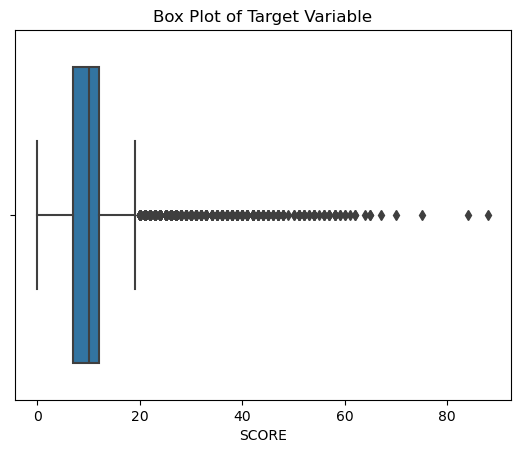

Number of outliers removed: 696


In [30]:
# Check for outliers using a box plot
sns.boxplot(x=rd['SCORE'])
plt.title("Box Plot of Target Variable")
plt.show()

# Calculate the IQR (Interquartile Range)
Q1 = rd['SCORE'].quantile(0.25)
Q3 = rd['SCORE'].quantile(0.75)
IQR = Q3 - Q1
# Define upper and lower bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
outliers = (rd['SCORE'] < lower_bound) | (rd['SCORE'] > upper_bound)
rd = rd[~outliers]

# Display the number of removed outliers
print("Number of outliers removed:", sum(outliers))